In [2]:
# kernel must be msd2
import pandas as pd
import constant as c
import geopandas as gpd
import numpy as np
from shapely.wkt import loads

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran

import contextily as cx
# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn
import pandas
import geopandas
import numpy
import matplotlib.pyplot as plt

from pyproj import CRS
import warnings; warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/woolee/anaconda3/envs/msd2/lib/python3.9/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)
/Users/woolee/anaconda3/envs/msd2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Get Data

In [3]:
# then read the data
df_2020 = pd.read_csv('../asset/preprocess/df_2020.csv', index_col=0)
df_2020['geometry_grids'] = df_2020['geometry_grids'].apply(lambda x: loads(x))
df_2021 = pd.read_csv('../asset/preprocess/df_2021.csv', index_col=0)
df_2021['geometry_grids'] = df_2021['geometry_grids'].apply(lambda x: loads(x))
df_2022 = pd.read_csv('../asset/preprocess/df_2022.csv', index_col=0)
df_2022['geometry_grids'] = df_2022['geometry_grids'].apply(lambda x: loads(x))

crs = 'EPSG:5179'  # Specify the coordinate reference system
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=df_2020['geometry_grids'], crs=crs)
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=df_2021['geometry_grids'], crs=crs)
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry=df_2022['geometry_grids'], crs=crs)

gdf_2020_scbd = gdf_2020[gdf_2020['sigungunm'].isin(c.SCBD_NMS)]
gdf_2020_gbd = gdf_2020[gdf_2020['sigungunm'].isin(c.GBD_NMS)]
gdf_2020_ybd = gdf_2020[gdf_2020['sigungunm'].isin(c.YBD_NMS)]
gdf_2021_scbd = gdf_2021[gdf_2021['sigungunm'].isin(c.SCBD_NMS)]
gdf_2021_gbd = gdf_2021[gdf_2021['sigungunm'].isin(c.GBD_NMS)]
gdf_2021_ybd = gdf_2021[gdf_2021['sigungunm'].isin(c.YBD_NMS)]
gdf_2022_scbd = gdf_2022[gdf_2022['sigungunm'].isin(c.SCBD_NMS)]
gdf_2022_gbd = gdf_2022[gdf_2022['sigungunm'].isin(c.GBD_NMS)]
gdf_2022_ybd = gdf_2022[gdf_2022['sigungunm'].isin(c.YBD_NMS)]


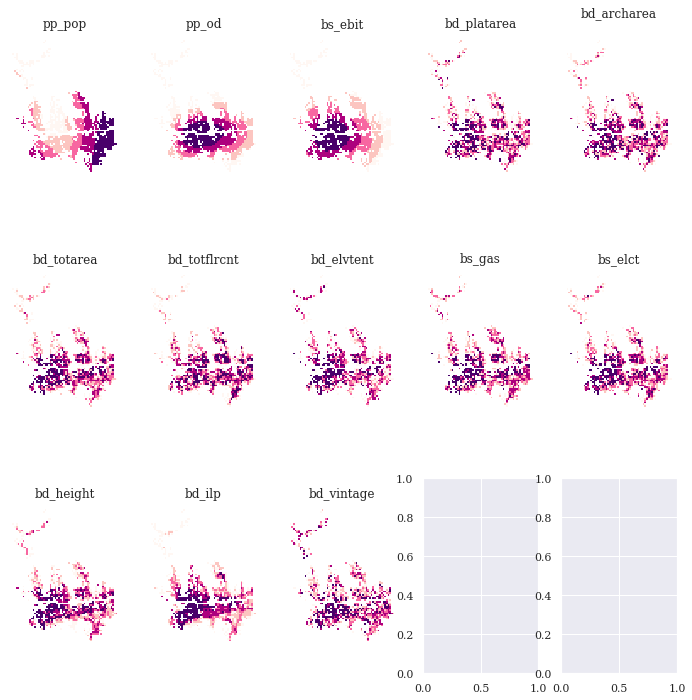

In [271]:
# Select the required columns for GWR
columns = ['grid_idx', 'pp_pop', 'pp_od', 'bs_ebit', 'bd_platarea', 'bd_archarea', 'bd_totarea',
           'bd_totflrcnt', 'bd_elvtent', 'bs_gas', 'bs_elct', 'bd_height', 'bd_ilp', 'bd_vintage']

dependent_var_cols = ['pp_pop', 'pp_od', 'bs_ebit', 'bd_platarea', 'bd_archarea', 'bd_totarea',
           'bd_totflrcnt', 'bd_elvtent', 'bs_gas', 'bs_elct', 'bd_height', 'bd_ilp', 'bd_vintage']

gdf = gdf_2022_scbd.copy()

f, axs = plt.subplots(nrows=3, ncols=5, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(dependent_var_cols):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [4]:
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt

# Assuming you have the necessary data for the GeoDataFrame
gdf = gpd.GeoDataFrame(gdf_2022_scbd, geometry='geometry_grids')

# Set the CRS for the GeoDataFrame
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf.explore(column="bs_ebit", zoom_start=13, width=1000, height=600)

In [273]:
# Assuming you have the necessary data for the GeoDataFrame
gdf = gpd.GeoDataFrame(gdf_2022_gbd, geometry='geometry_grids')

# Set the CRS for the GeoDataFrame
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf.explore(column="bs_ebit", zoom_start=13, width=1000, height=600)

In [279]:
# Assuming you have the necessary data for the GeoDataFrame
gdf = gpd.GeoDataFrame(gdf_2022_ybd, geometry='geometry_grids')

# Set the CRS for the GeoDataFrame
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf.explore(column="grid_idx", zoom_start=13, width=1000, height=600)

### Local Moran's I

In [438]:
def deduct_island(gdf, neighbors_threshold):
    """
    :params gdf
    :params neighbors_threshold
    :return gdf_filtered
    """
    # Deducting island grids
    w = Queen.from_dataframe(gdf)
    NEIGHBORS_THRESHOLD = neighbors_threshold
    gdf_first_index = gdf.index[0] # 1702 for gbd
    w_indexs = []
    for i in range(len(gdf)):
        num_neighbors = len(w.weights[i])
        if num_neighbors > NEIGHBORS_THRESHOLD:
            w_indexs.append(i)
    filtered_gdf_index = w_indexs + gdf_first_index
    gdf_filtered = gdf.loc[filtered_gdf_index]
    return gdf_filtered

In [439]:
# Declare gdf and set crs and filter(=deduct island)
gdf = gpd.GeoDataFrame(gdf_2022_scbd, geometry='geometry_grids')
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf_filtered = deduct_island(gdf, 2)

In [440]:
numpy.random.seed(123456)
w_filtered = Queen.from_dataframe(gdf_filtered)

# Calculate Moran's I for each variable
mi_results = [
    Moran(gdf_filtered[variable], w_filtered) for variable in dependent_var_cols
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(dependent_var_cols, mi_results)
]
# Display on table
table = pandas.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

('WARNING: ', 21, ' is an island (no neighbors)')
('WARNING: ', 35, ' is an island (no neighbors)')
('WARNING: ', 122, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')


Moran's I  P-value
Variable                        
pp_pop         0.991925    0.001
pp_od          0.966552    0.001
bs_ebit        0.990415    0.001
bd_platarea    0.217375    0.001
bd_archarea    0.225147    0.001
bd_totarea     0.338330    0.001
bd_totflrcnt   0.351110    0.001
bd_elvtent     0.332616    0.001
bs_gas         0.178828    0.001
bs_elct        0.217736    0.001
bd_height      0.504285    0.001
bd_ilp         0.788828    0.001
bd_vintage     0.217569    0.001

### GWR(Geographically Weighted Regression)

In [441]:
# import libs
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

In [442]:
VAR_COLS = [
    'pp_pop', # X1
    'pp_od', # X2
    'bs_ebit', # X3
    'bs_gas', # X4
    'bs_elct', # X5
    'bd_platarea', # X6
    'bd_archarea', # X7
    'bd_totarea', # X8
    'bd_totflrcnt', # X9
    'bd_elvtent', # X10
    'bd_height', # X11
    'bd_vintage' # X12
    ]

TARGET_COL = ['bd_ilp'] # y is individual land price

# Assuming you have the necessary data for the GeoDataFrame
gdf = gpd.GeoDataFrame(gdf_2022, geometry='geometry_grids')

# Filling any data point that is nan -> fill by mean value of column
mean_values = gdf[VAR_COLS].mean()
gdf[VAR_COLS] = gdf[VAR_COLS].fillna(mean_values) # Fill NaN values with the mean values
# Calculate the threshold value for the top 25%
threshold = gdf['bd_ilp'].quantile(0.75)
# Select the rows where 'bd_ilp' is in the top 25%
gdf = gdf[gdf['bd_ilp'] >= threshold]

In [443]:
X = gdf[VAR_COLS].values
y = gdf[TARGET_COL].values.reshape((-1,1)) 
print(X.shape)
print(y.shape)

# normalize
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

lat = gdf.centroid.x
lng = gdf.centroid.y
coords = list(zip(lat,lng))

(955, 12)
(955, 1)


In [444]:
# calibrate GWR MODEL
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(coords, y, X, gwr_bw).fit()

311.0


In [445]:
gwr_results.localR2[0:10]

array([[0.54225809],
       [0.53897963],
       [0.54174727],
       [0.54344022],
       [0.54452671],
       [0.54536615],
       [0.53863181],
       [0.54146948],
       [0.54440735],
       [0.54129441]])

In [446]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 955
Number of covariates:                                                    13

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            633.980
Log-likelihood:                                                   -1159.457
AIC:                                                               2344.915
AICc:                                                              2347.362
BIC:                                                              -5829.752
R2:                                                                   0.336
Adj. R2:                                                              0.328

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Incremental Spatial Autocorrelation

In [2]:
# kernel must be msd2
import pandas as pd
import constant as c
import geopandas as gpd
import numpy as np
from shapely.wkt import loads

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran

import contextily as cx
# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn
import pandas
import geopandas
import numpy
import matplotlib.pyplot as plt

from pyproj import CRS
import warnings; warnings.filterwarnings('ignore')

# then read the data
df_2020 = pd.read_csv('../asset/preprocess/df_2020.csv', index_col=0)
df_2020['geometry_grids'] = df_2020['geometry_grids'].apply(lambda x: loads(x))
df_2021 = pd.read_csv('../asset/preprocess/df_2021.csv', index_col=0)
df_2021['geometry_grids'] = df_2021['geometry_grids'].apply(lambda x: loads(x))
df_2022 = pd.read_csv('../asset/preprocess/df_2022.csv', index_col=0)
df_2022['geometry_grids'] = df_2022['geometry_grids'].apply(lambda x: loads(x))

crs = 'EPSG:5179'  # Specify the coordinate reference system
gdf_2020 = gpd.GeoDataFrame(df_2020, geometry=df_2020['geometry_grids'], crs=crs)
gdf_2021 = gpd.GeoDataFrame(df_2021, geometry=df_2021['geometry_grids'], crs=crs)
gdf_2022 = gpd.GeoDataFrame(df_2022, geometry=df_2022['geometry_grids'], crs=crs)

gdf_2020_scbd = gdf_2020[gdf_2020['sigungunm'].isin(c.SCBD_NMS)]
gdf_2020_gbd = gdf_2020[gdf_2020['sigungunm'].isin(c.GBD_NMS)]
gdf_2020_ybd = gdf_2020[gdf_2020['sigungunm'].isin(c.YBD_NMS)]
gdf_2021_scbd = gdf_2021[gdf_2021['sigungunm'].isin(c.SCBD_NMS)]
gdf_2021_gbd = gdf_2021[gdf_2021['sigungunm'].isin(c.GBD_NMS)]
gdf_2021_ybd = gdf_2021[gdf_2021['sigungunm'].isin(c.YBD_NMS)]
gdf_2022_scbd = gdf_2022[gdf_2022['sigungunm'].isin(c.SCBD_NMS)]
gdf_2022_gbd = gdf_2022[gdf_2022['sigungunm'].isin(c.GBD_NMS)]
gdf_2022_ybd = gdf_2022[gdf_2022['sigungunm'].isin(c.YBD_NMS)]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/woolee/anaconda3/envs/msd2/lib/python3.9/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)
/Users/woolee/anaconda3/envs/msd2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran_Local
from libpysal.weights import full
# Declare gdf and set crs and filter(=deduct island)
gdf = gpd.GeoDataFrame(gdf_2022_gbd, geometry='geometry_grids')
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)

In [ ]:
def incremental_sar(gdf):
    first_gdf_idx    = list(gdf.index)[0] # 650(for gbd)
    centroid_gdf_idx = gdf['bd_height'].idxmax()
    centroid_w_idx = centroid_gdf_idx - first_gdf_idx
    # print(f'Centroid Building is {gdf.loc[centroid_idx].bdnm}\ngdf_idx is {centroid_gdf_idx}\nw_idx is {centroid_w_idx}')
    init_w = Queen.from_dataframe(gdf)
    cluster = [centroid_w_idx] # we manage by gdf_idx, not w_idx because w_idx changes everytime
    for phase in range(50):
        if phase == 0:
            tba_w_idxs = init_w.neighbors[centroid_w_idx]
        else :
            prev_w_idx = tba_w_idxs
            tba_w_idxs = []
            for w_idx in prev_w_idx:
                tba_idxs = init_w.neighbors[w_idx]
                tba_w_idxs.extend(tba_idxs) # tba: to be added
        assert len(tba_w_idxs) > 0
        cluster.extend(tba_w_idxs)
        cluster = list(set(cluster))
        cluster_gdf_idxs = [x + first_gdf_idx for x in list(cluster)]
        new_gdf = gdf.loc[cluster_gdf_idxs]
        new_w = Queen.from_dataframe(new_gdf)
        new_w.transform = 'r'
        moran = Moran(new_gdf['bd_ilp'], new_w)
        z = moran.z_sim
        print('bdnms', new_gdf.bdnm.values)
        print('round', phase)
        print('z', z)
                
incremental_sar(gdf)   

In [3]:
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran_Local
from libpysal.weights import full


In [455]:
# gdf = gdf_2022_gbd.copy()
# gdf = gdf.reset_index(drop=True)

# Declare gdf and set crs and filter(=deduct island)
gdf = gpd.GeoDataFrame(gdf_2022_scbd, geometry='geometry_grids')
crs = CRS.from_epsg(5179)
gdf = gdf.set_crs(crs)
gdf_first_index = list(gdf.index)[0] # 650 for scbd
print(gdf.index)
print(gdf_first_index)
gdf_filtered = deduct_island(gdf, 2)

Int64Index([ 650,  651,  652,  653,  654,  655,  656,  657,  658,  659,
            ...
            1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701],
           dtype='int64', length=1052)
650


In [476]:


COLS = [
    'pp_pop', # X1
    'pp_od', # X2
    'bs_ebit', # X3
    'bs_gas', # X4
    'bs_elct', # X5
    'bd_platarea', # X6
    'bd_archarea', # X7
    'bd_totarea', # X8
    'bd_totflrcnt', # X9
    'bd_elvtent', # X10
    'bd_height', # X11
    'bd_vintage', # X12
    'bd_ilp'
    ]

def incremental_spread(gdf, centroid_gdf_index, w, gdf_first_index):
    centroid_w_index = centroid_gdf_index - gdf_first_index
    cluster_w_indexes = {centroid_w_index} # first, append centroid grid
    cluster_zscore = 0

    while True:
        adjacent_grids = w.neighbors[centroid_w_index]
        best_zscore = cluster_zscore
        
        for grid_w_index in adjacent_grids:
            if grid_w_index not in cluster_w_indexes:
                new_cluster_w_indexes = cluster_w_indexes | {grid_w_index}
                new_cluster_gdf_indexes = [x + gdf_first_index for x in list(new_cluster_w_indexes)] # 1,2,3,4,5 -> 1001, 1002, 1003, 1004, 1005
                print(new_cluster_gdf_indexes)
                new_gdf = gdf.loc[new_cluster_gdf_indexes]
                new_w = Queen.from_dataframe(new_gdf)
                new_w.transform = 'r' 
                print(new_w.weights)
                moran = Moran(new_gdf['bd_ilp'], new_w) # global moran i
                print(moran)
                zscore = moran.z_sim
                print(zscore)
                if zscore > best_zscore:
                    best_cluster_w_indexes = new_cluster_w_indexes
                    best_zscore = zscore
        if best_cluster_w_indexes is None:
            break
        # cluster = cluster | {best_grid}
        cluster_zscore = best_zscore
        # central_grid_id = best_grid
    return best_cluster_w_indexes, cluster_zscore


# def calculate_similarity(gdf, cluster, w):
#     similarity_scores = {}
#     for grid_id in gdf.index:
#         if grid_id in cluster:
#             similarity_scores[grid_id] = 1.0
#         else:
#             new_cluster = cluster | {grid_id}
#             zscore = Moran_Local(gdf.loc[new_cluster, COLS].values, w).Is[grid_id]
#             similarity_scores[grid_id] = zscore
#     return similarity_scores

# Load GeoDataFrame and create spatial weight matrix
w = Queen.from_dataframe(gdf_filtered)
# Find the central grid with the highest 'bd_height'
centroid_idx = gdf['bd_height'].idxmax()
print(centroid_idx)
print(gdf.loc[centroid_idx].bdnm)

# Perform incremental spreading
cluster, cluster_zscore = incremental_spread(gdf, centroid_idx, w, gdf_first_index)
cluster
# # Calculate similarity scores for each grid
# similarity_scores = calculate_similarity(gdf, cluster, w)


# # Visualize the similarity scores
# gdf['similarity_score'] = gdf.index.map(similarity_scores)
# gdf.plot(column='similarity_score', cmap='coolwarm', legend=True)

825
SK서린동빌딩
[826, 825]
{0: [1.0], 1: [1.0]}
nan
[815, 825]
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
{0: [], 1: []}
nan
[816, 825]
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
{0: [], 1: []}
nan
[817, 825]
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
{0: [], 1: []}
nan
[840, 825]
{0: [1.0], 1: [1.0]}
nan
[839, 825]
{0: [1.0], 1: [1.0]}
nan
[824, 825]
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
{0: [], 1: []}
nan


UnboundLocalError: local variable 'best_cluster_w_indexes' referenced before assignment

bdnms ['풍림아이원매직' 'The Asset' '삼성생명서초타워' '강남역 한화오벨리스크' '삼성전자빌딩' '대각빌딩']
round 0
z 2.3318193953349504
bdnms ['강남애니타워, 대우도씨에빛2, 호정빌딩, 솔라티움시티 강남, 비트빌, 스타크 강남빌딩' '풍림아이원매직' 'The Asset'
 '삼성생명서초타워' 'GT TOWER, 가락빌딩' '강남역 한화오벨리스크' '삼성전자빌딩' '대각빌딩'
 'BNK디지털타워, 재전빌딩, 강남빌딩' '부띠크 모나코' '타임빌딩, BMW A/S센터 강남사옥']
round 1
z 1.876818553202615
bdnms ['강남애니타워, 대우도씨에빛2, 호정빌딩, 솔라티움시티 강남, 비트빌, 스타크 강남빌딩' '벨라채오피스텔' '풍림아이원매직'
 'The Asset' '삼성생명서초타워' 'GT TOWER, 가락빌딩' '세계빌딩, 강남 누드죤빌딩, 강남빌딩'
 '익산빌딩, 우영빌딩, 강남역 인앤인, 강남역 롯데골드로즈, 아르누보씨티2, ENDEAVOR TOWER' 'NoData'
 '강남역 한화오벨리스크' '삼성전자빌딩' '대각빌딩' 'BNK디지털타워, 재전빌딩, 강남빌딩' '부띠크 모나코'
 '타임빌딩, BMW A/S센터 강남사옥']
round 2
z 2.812085438516851
bdnms ['NoData' 'BNK디지털타워, 재전빌딩, 강남빌딩' '부띠크 모나코' '타임빌딩, BMW A/S센터 강남사옥'
 '벨라채오피스텔' '풍림아이원매직' 'The Asset' '삼성생명서초타워' 'GT TOWER, 가락빌딩'
 '세계빌딩, 강남 누드죤빌딩, 강남빌딩'
 'BLOCK77, 서초동유빌딩, FIRENZE, 대동빌딩, 파고다타워, 삼영빌딩, 강남 지웰타워2' '릿타워'
 '강남역 한화오벨리스크' '삼성전자빌딩' '대각빌딩' '강남미래타워, 갤럭시타워, 서전빌딩, EWR빌딩'
 '익산빌딩, 우영빌딩, 강남역 인앤인, 강남역 롯데골드로즈, 아르누보씨티2, ENDEAVOR TOWER'
 '강남애니타워,

In [482]:
# Zscore의 조합을 찾아서 cluster 내 zscore 극단치를 살펴보아야 한다.
# 나의 경우 business, building, people이 있고 pca를 통해 각각 대분류에서 1개 요소만 추출할 필요가 있으며,
# 그중에서도 3개 남은 조합에서도 최종적으로 1개 요소만 추려내야할 듯 하다.

# 가령, 모든 grid에 대해 bs, bd, pp의 zscore를 정리해서 similaritiy를 추려내고
# 해당 zscore 조합에서 의미있는 수치 이상인 애들만 추려내로 될 듯하다

In [496]:
round

<function round(number, ndigits=None)>

In [208]:
gdf.loc[598]

grid_idx                                                      31409
pp_pop                                                108328.971548
pp_od                                                8556129.347587
bs_ebit                                         2792133916214.39209
geometry_grids    POLYGON ((958135.230213883 1944165.54807064, 9...
sigungunm                                                       서초구
platplc                                     서울특별시 서초구 서초동 1320-10번지
x                                                        127.026941
y                                                         37.496574
x_5179                                                958184.265823
y_5179                                               1944251.351315
bdnm                                                         삼성전자빌딩
bd_platarea                                                 13108.3
bd_archarea                                                 7044.66
bd_totarea                                      

In [170]:
gdf.loc[gdf['bd_height'].idxmax()]

grid_idx                                                      31409
pp_pop                                                108328.971548
pp_od                                                8556129.347587
bs_ebit                                         2792133916214.39209
geometry_grids    POLYGON ((958135.230213883 1944165.54807064, 9...
sigungunm                                                       서초구
platplc                                     서울특별시 서초구 서초동 1320-10번지
x                                                        127.026941
y                                                         37.496574
x_5179                                                958184.265823
y_5179                                               1944251.351315
bdnm                                                         삼성전자빌딩
bd_platarea                                                 13108.3
bd_archarea                                                 7044.66
bd_totarea                                      

In [196]:
w.neighbors[2300]

KeyError: 2300